In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import geopandas as gpd
import xarray as xr

from glob import glob
from tqdm import tqdm
from pathlib import Path
from datetime import timedelta
from shapely import wkt
from shapely.geometry import Point, LineString

datasets = Path("/nas/cee-water/cjgleason/data")
era5_dir = datasets / "ERA5-Land/sub_basin_timeseries"

save_dir = Path("/nas/cee-water/cjgleason/ted/swot-ml/data/distributed")
metadata_dir = save_dir / "metadata"
sites_dir = metadata_dir / "site_lists"

fig_dir = save_dir / '_figures' / 'train_test'

basin = 'Ohio'
# basin = 'Ohio_Portsmouth'
# basin = 'Upper_Miss'
# basin = 'Missouri'

matchups = gpd.read_file(metadata_dir / f'{basin}_matchups.geojson').set_index("HYBAS_ID")
all_sites = matchups[~matchups['site_id'].isna()]

<Axes: >

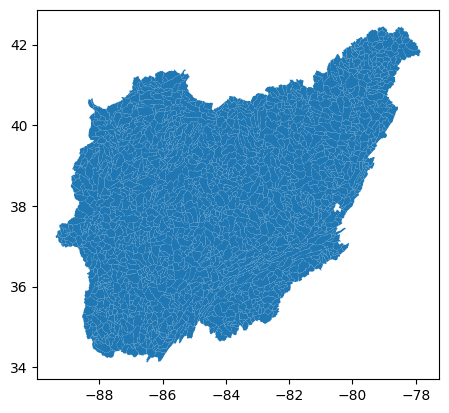

In [7]:
matchups.plot()

In [4]:
matchups['site_id'].dropna()

HYBAS_ID
7090486510    USGS-03011020
7090488570    USGS-03010820
7090490270    USGS-03010500
7090490720    USGS-03021350
7090493310    USGS-03021520
                  ...      
7090663030    USGS-03584600
7090664730    USGS-03586500
7090665120    USGS-03590000
7090666690    USGS-03575100
7090669310    USGS-03574500
Name: site_id, Length: 460, dtype: object

In [2]:
def write_index_sites(df, stem):
    sites = list(df.index.astype(str))
    with open(metadata_dir/'site_lists'/f'{stem}.txt', "w") as file:
        file.write("\n".join(sites) + "\n")

write_index_sites(all_sites, f'{basin}_all')

In [3]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def plot_train_test(_train, _test):
    _train['subset'] = 'train'
    _test['subset'] = 'test'
    all_basin = pd.concat([_train, _test])

    colors = ['tab:blue', 'tab:orange']
    cmap = ListedColormap(colors)

    
    plt.close('all')
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    all_basin.plot(column='subset', categories=['train','test'], legend=True, ax=axes[0], cmap=cmap)
    # Move legend to top left
    legend = axes[0].get_legend()
    legend.set_bbox_to_anchor((1, 1)) 

    bin_range = (
        np.floor(np.log10(all_basin['hybas_area'].min())),
        np.ceil(np.log10(all_basin['hybas_area'].max()))
    )
    # bmax = np.ceil(np.log10(train_df['hybas_area'].max()))
    # bmax = np.ceil(np.log10(train_df['hybas_area'].max()))
    
    axes[1].hist(np.log10(_train['hybas_area']), bins=10, range=bin_range)
    axes[1].hist(np.log10(_test['hybas_area']), alpha=0.7, bins=10, range=bin_range)
    axes[1].set_xlabel('Log10 Upstream Area (km)')

    plt.suptitle(f'{basin} watershed train / test')
    fig.tight_layout()
    
    
    return fig, axes

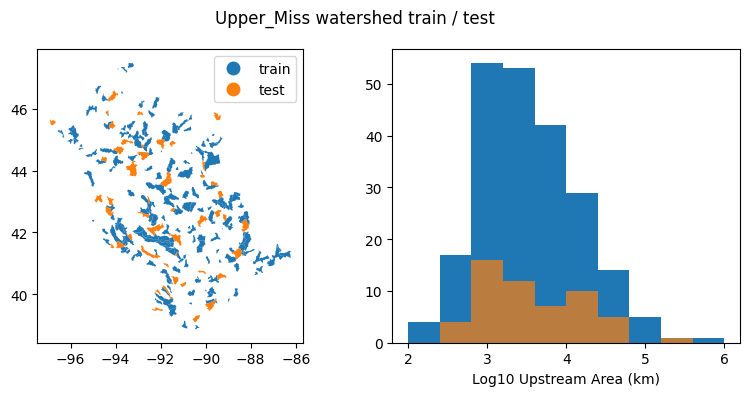

In [4]:
train_df = all_sites.sample(frac=0.8, random_state=42)
test_df = all_sites.drop(train_df.index)

fig, axes = plot_train_test(train_df, test_df)
fig.savefig(fig_dir / f'random_split_{basin}.png', dpi=300)

write_index_sites(train_df, f'{basin}_random_train')
write_index_sites(test_df, f'{basin}_random_test')

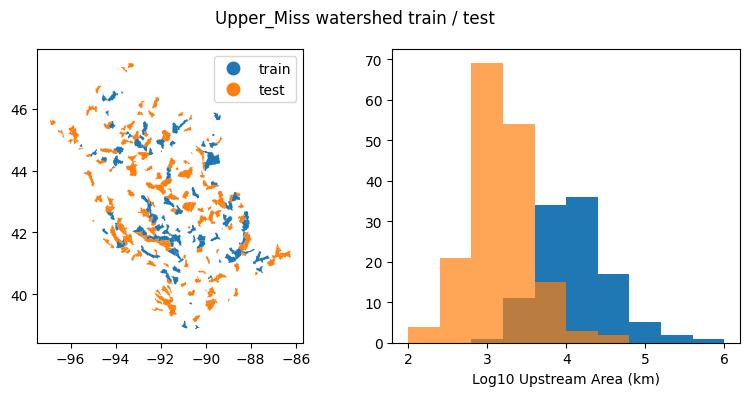

In [5]:
has_sword = ~all_sites['reach_id'].isna()
sword_sites = all_sites[has_sword].copy()
other_sites = all_sites[~has_sword].copy()

fig, axes = plot_train_test(sword_sites, other_sites)
fig.savefig(fig_dir / f'swot_split_{basin}.png', dpi=300)

write_index_sites(sword_sites, f'{basin}_Sword')
write_index_sites(other_sites, f'{basin}_noSword')